In [17]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel
from operator import add
import seaborn as sns

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

In [18]:
def parseLine(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector = [x for i, x in enumerate(vector) if i not in [1, 2, 3]]
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine).cache()

# we only need the data, not the label
data = labelsAndData.map(lambda x : x[1]).cache()

# number of connections
n = data.count()

In [19]:
print("Number of connections:", n)
print("Details per connection:", len(data.first()))

Number of connections: 4898431
Details per connection: 38


In [20]:
x = labelsAndData.map(lambda x: x[0]).distinct().count()
print("Total number of labels:\n", x)
y = labelsAndData.map(lambda x : (x[0], 1)).reduceByKey(add).collect()
#print("The labels available and their occurrence in the dataset is:\n")
#for _ in y:
#    print("%20s\t%d" %(_[0], _[1]))

Total number of labels:
 23


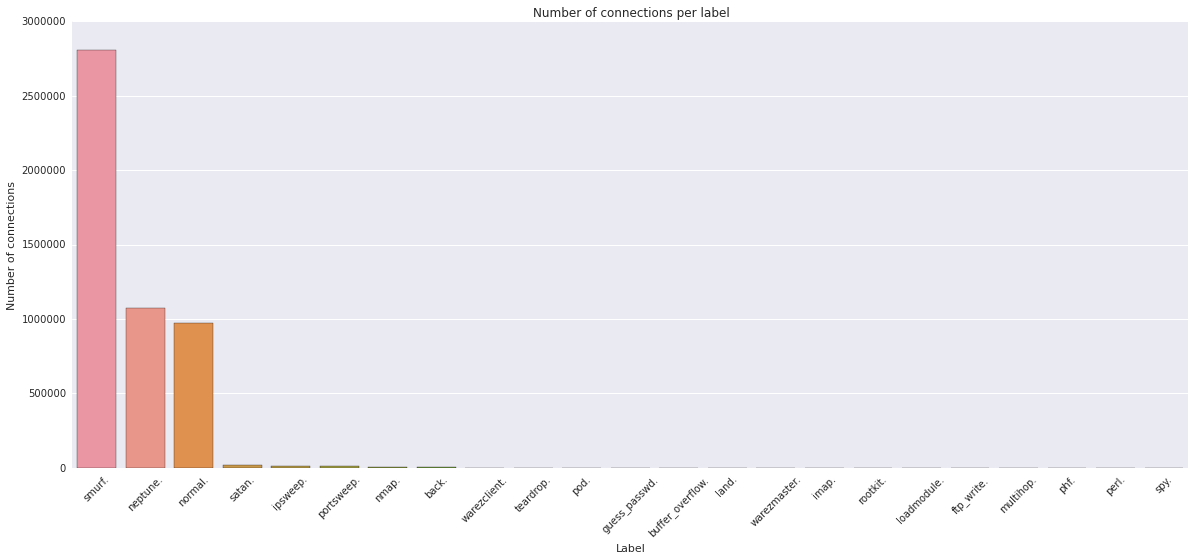

In [21]:
y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

In [22]:
#amount of connections of the first 3 labels.
print("amount of connections of the first 3 labels:\t", y[0][1]+y[1][1]+y[2][1])

amount of connections of the first 3 labels:	 4852684


In [25]:
clusters = KMeans.train(data, 2, maxIterations=10, runs=10, initializationMode="random")

In [26]:
from operator import add

__ = labelsAndData.map(lambda x : (clusters.predict(x[1]), 1)).reduceByKey(add).collect()
for _ in __:
    print("Cluster %5d\tNumber of elements: %10d" %(_[0], _[1]))

Cluster     0	Number of elements:          5
Cluster     1	Number of elements:    4898426


In [27]:
sampled = data.sample(withReplacement=False, fraction=0.01)
datax = sampled.map(lambda x: x[0]).collect()
datay = sampled.map(lambda x: x[1]).collect()
dataz = sampled.map(lambda x: x[2]).collect()
labels_ = sampled.map(lambda x: clusters.predict(x)).collect()

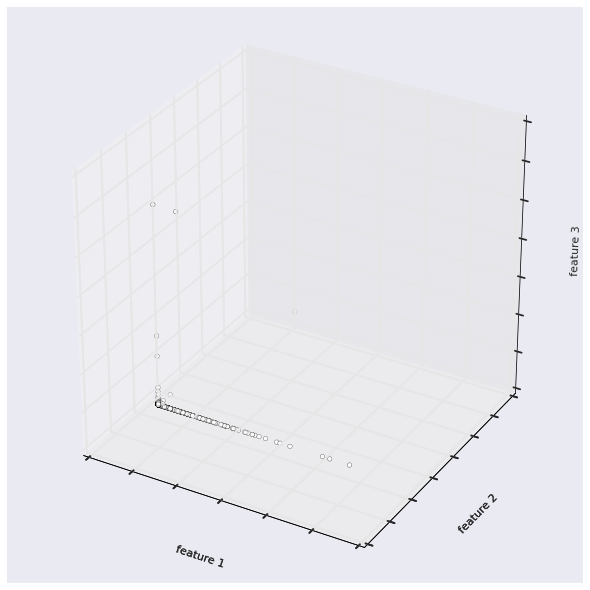

In [28]:
#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter(datax, datay, dataz, c=labels_)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

In [49]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import PCA as PCAmllib

vectorData = data.map(Vectors.dense)
PCAModel3 = PCAmllib(3).fit(vectorData)
pcaData3 = PCAModel3.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

PCAModel2 = PCAmllib(2).fit(vectorData)
pcaData2 = PCAModel2.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

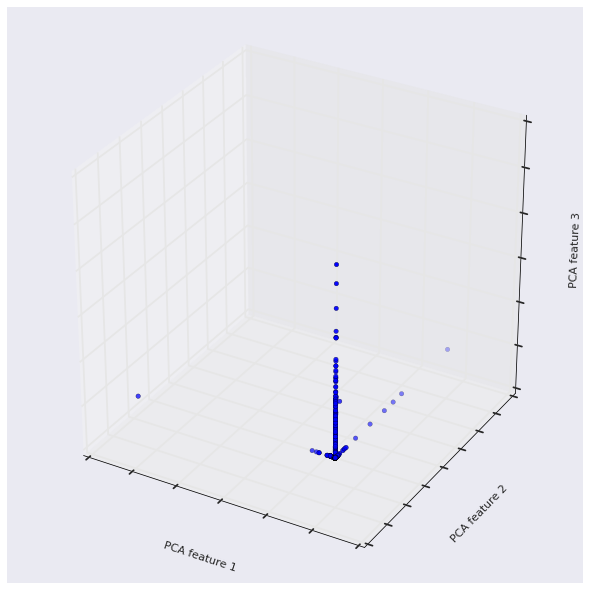

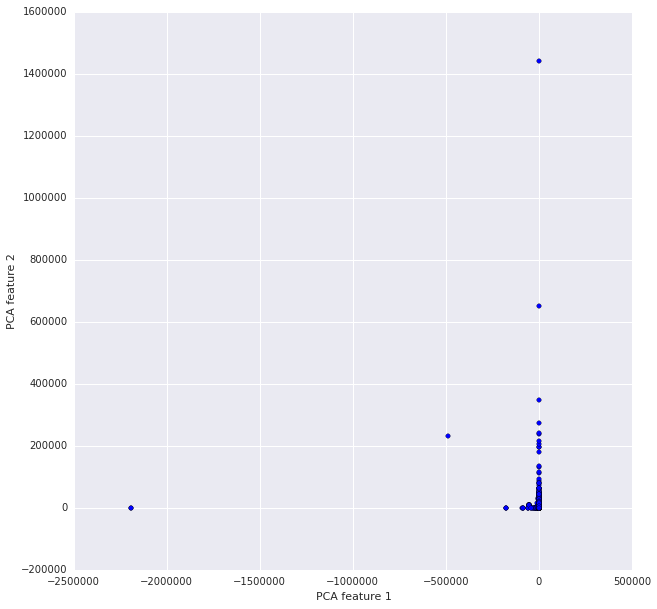

In [59]:
#pca plot
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig)

ax.scatter([x[0] for x in pcaData3], [x[1] for x in pcaData3], [x[2] for x in pcaData3])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA feature 1')
ax.set_ylabel('PCA feature 2')
ax.set_zlabel('PCA feature 3')
plt.show()

fig = plt.figure(1, figsize=(10, 10))

plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')

plt.show()

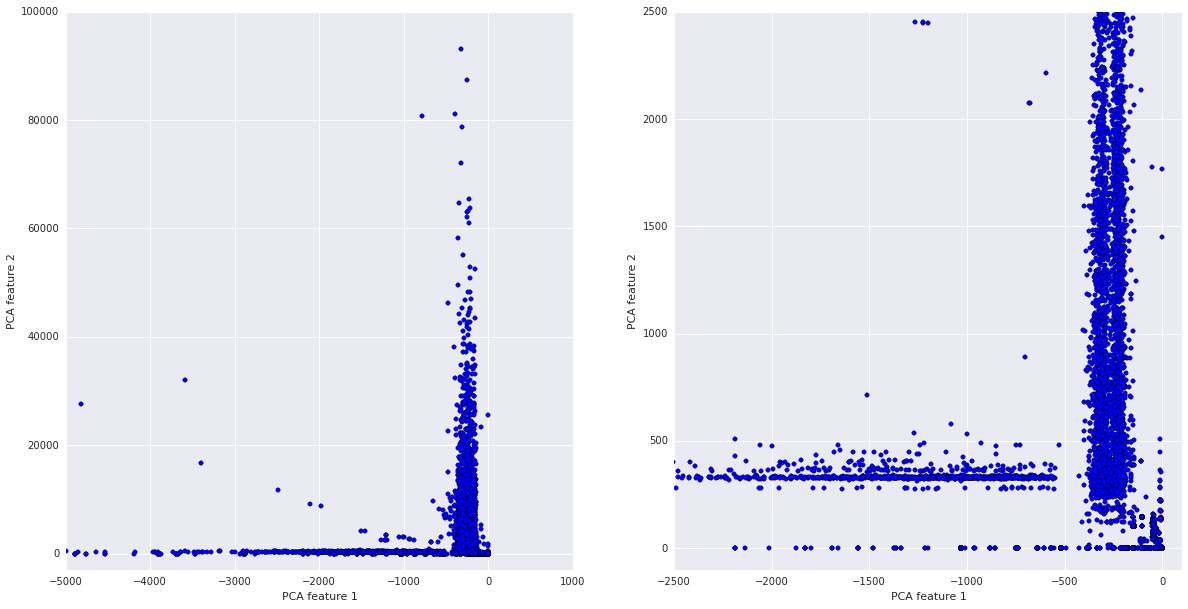

In [63]:
fig = plt.figure(1, figsize=(20, 10))
plt.subplot(121)
plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.xlim(-5000,1000)
plt.ylim(-3000, 100000)

plt.subplot(122)
plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.xlim(-2500,100)
plt.ylim(-100, 2500)
plt.show()

In [48]:
from pyspark.ml.feature import PCA as PCAml
from pyspark.sql import SQLContext
from pyspark.ml.linalg import Vectors
sqlContext = SQLContext(sc)
 
def make_it_work(array): #dummy function because Vectors.dense(array) would arise errors.
    return (Vectors.dense(array),)
 
vectorData = data.map(make_it_work)
df = sqlContext.createDataFrame(v_data,["features"]) #for the pca with this library we have to use a dataframe
pca = PCAml(k=3, inputCol="features", outputCol="pca_features")
model = pca.fit(df)
model.explainedVariance

DenseVector([0.6805, 0.3195, 0.0])

In [25]:
import time

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(closest_center, point, sqrt=False)

In [26]:
t1 = time.time()
WSSSE = data.map(lambda x : error(clusters, x)).reduce(add)
print("Within Set Sum of Squared Error = " + str(WSSSE))
print("Time needed:", time.time()-t1)

Within Set Sum of Squared Error = 3.05254895755e+18
Time needed: 21.522828340530396


In [27]:
t1 = time.time()
print(clusters.computeCost(data))
print("Time needed:", time.time()-t1)

3.0525489575482665e+18
Time needed: 5.279970645904541


In [28]:
clusterLabelCount = labelsAndData.map(lambda x : ((clusters.predict(x[1]), x[0]), 1)).reduceByKey(add).collect()

for item in clusterLabelCount:
    print("Label #%d\tClass:%20s\tOccurrences:%10d" %(item[0][0],item[0][1],item[1]))

Label #1	Class:               back.	Occurrences:      2203
Label #1	Class:               imap.	Occurrences:        12
Label #1	Class:           teardrop.	Occurrences:       979
Label #1	Class:                pod.	Occurrences:       264
Label #1	Class:              satan.	Occurrences:     15892
Label #1	Class:               land.	Occurrences:        21
Label #1	Class:          portsweep.	Occurrences:     10408
Label #1	Class:       guess_passwd.	Occurrences:        53
Label #1	Class:           multihop.	Occurrences:         7
Label #1	Class:            neptune.	Occurrences:   1072017
Label #1	Class:              smurf.	Occurrences:   2807886
Label #1	Class:             normal.	Occurrences:    972781
Label #1	Class:               nmap.	Occurrences:      2316
Label #1	Class:        warezmaster.	Occurrences:        20
Label #1	Class:                phf.	Occurrences:         4
Label #1	Class:                spy.	Occurrences:         2
Label #1	Class:         loadmodule.	Occurrences:        

In [29]:
nrLabelsPerCluster = labelsAndData.map(lambda x : (clusters.predict(x[1]), x[0])).groupByKey().collect()
for _ in nrLabelsPerCluster:
    print("Cluster %5d\tNumber of classes: %10d" %(_[0], len(np.unique(_[1].data))))

Cluster     0	Number of classes:          1
Cluster     1	Number of classes:         23


In [30]:
# k: the number of clusters
def clusteringScore(data, k, withCenters=False):
    clusters = KMeans.train(data, k, maxIterations=10, runs=10, initializationMode="random")
    # calculate mean square error
    if withCenters is True:
        return (clusters.computeCost(data), len(clusters.centers))
    return clusters.computeCost(data)

In [31]:
k_vector = [2,5,10,23,30,50,70,100,120,200,300,400]

scores = [clusteringScore(data, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =   2, (effective nr. of clusters =   2) WSSSE = 3052548957548266496
k =   5, (effective nr. of clusters =   5) WSSSE = 1154456223993177600
k =  10, (effective nr. of clusters =   5) WSSSE = 1162421760546891520
k =  23, (effective nr. of clusters =  16) WSSSE = 994285071487709440
k =  30, (effective nr. of clusters =  19) WSSSE = 994224338793713408
k =  50, (effective nr. of clusters =  28) WSSSE = 1092446662800909440
k =  70, (effective nr. of clusters =  43) WSSSE = 966005455499744384
k = 100, (effective nr. of clusters =  46) WSSSE = 966022222212252800
k = 120, (effective nr. of clusters =  63) WSSSE = 990491690309865856
k = 200, (effective nr. of clusters =  93) WSSSE = 965993316209542656
k = 300, (effective nr. of clusters = 145) WSSSE = 965939323277659136
k = 400, (effective nr. of clusters = 198) WSSSE = 965942746630343808


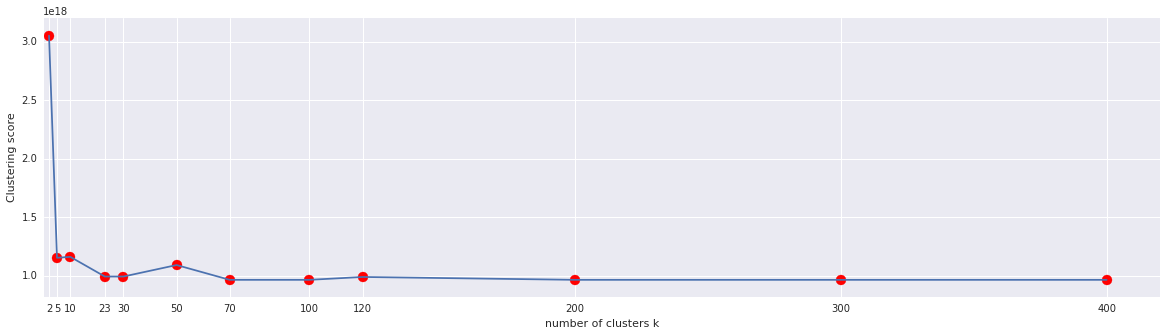

In [32]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([0, np.max(k_vector)*1.05, 0.85*np.min(_), 1.05*np.max(_)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.xticks(k_vector)
plt.show()

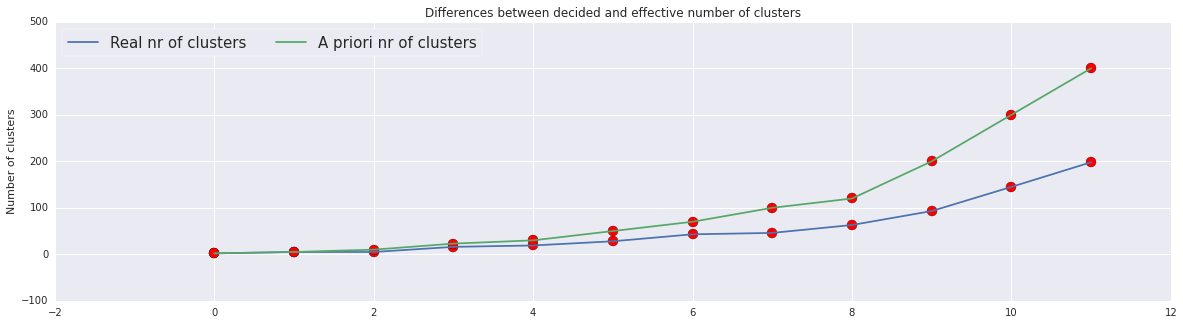

In [33]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

In [34]:
def normalizeData(labelsAndData):
     # calculate means
    means = labelsAndData.map(lambda x:x[1]).mean()
    # calculate standard deviation of each feature
    stdevs = np.sqrt(labelsAndData.map(lambda x : (x[1]-means)**2).mean())
    
    stdevs[stdevs==0] = 1
    def normalize(point):
        return (point[0],(point[1]-means)/stdevs)

    return labelsAndData.map(lambda x: normalize(x))

labelsAndDataNorm = normalizeData(labelsAndData).cache()
normalizedData = labelsAndDataNorm.map(lambda x: x[1]).cache()
print(normalizedData.take(5))

[array([ -6.68331854e-02,  -1.72038228e-03,   6.81884351e-02,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e-03,  -4.54646139e-03,
        -3.28458917e-03,  -9.57233922e-03,  -8.50457842e-03,
        -2.87561127e-02,   0.00000000e+00,  -6.38979005e-04,
        -2.89113034e-02,  -1.57541507e+00,  -1.19624324e+00,
        -4.66042614e-01,  -4.65755574e-01,  -2.48285775e-01,
        -2.48130352e-01,   5.39733093e-01,  -2.56056520e-01,
        -2.01059296e-01,  -3.63913926e+00,  -1.78651044e+00,
        -1.83302273e+00,  -2.82939000e-01,  -1.25793664e+00,
        -1.56668488e-01,  -4.66404784e-01,  -4.65453641e-01,
        -2.50831829e-01,  -2.49631966e-01]), array([ -6.68331854e-02,  -1.77667956e-03,   5.32451452e-03,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e-

In [35]:
k_vector = [60,70,80,90,100,110]
scores = [clusteringScore(normalizedData, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =  60, (effective nr. of clusters =  30) WSSSE = 71907910
k =  70, (effective nr. of clusters =  37) WSSSE = 66333959
k =  80, (effective nr. of clusters =  39) WSSSE = 66426038
k =  90, (effective nr. of clusters =  51) WSSSE = 71016365
k = 100, (effective nr. of clusters =  53) WSSSE = 59803588
k = 110, (effective nr. of clusters =  56) WSSSE = 55318890


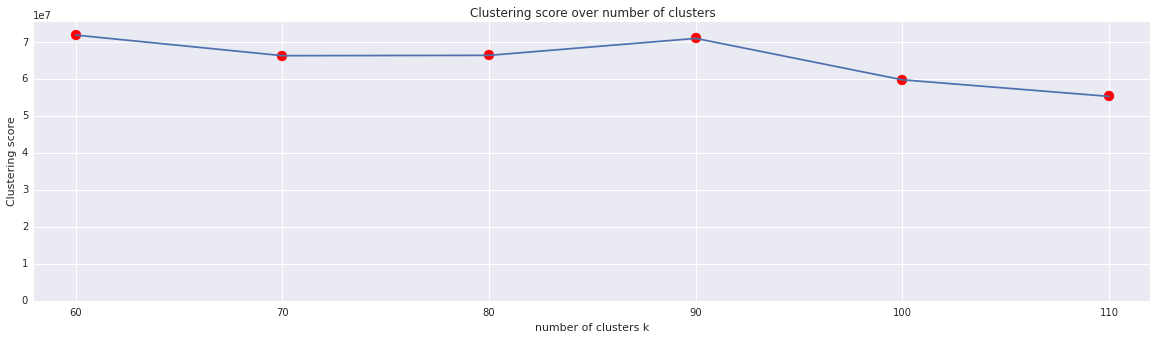

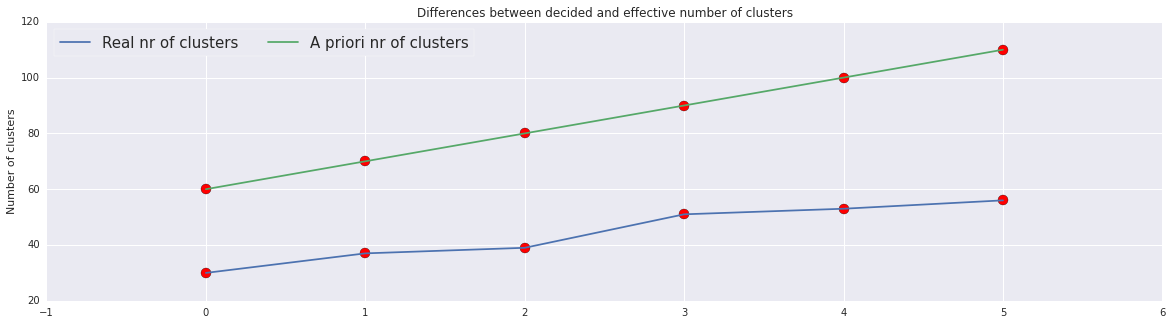

In [36]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([58,112, 0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.title("Clustering score over number of clusters")
plt.xticks(k_vector)
plt.show()

# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

In [37]:
#let's use k as the best in the previous question = 80
clusters = KMeans.train(normalizedData, k=80, maxIterations=10, runs=10, initializationMode="random")

#get three axis on the first three attributes
sampledNormalized = normalizedData.sample(withReplacement=False, fraction=0.01)
datax_norm = sampledNormalized.map(lambda x: x[0]).collect()
datay_norm = sampledNormalized.map(lambda x: x[1]).collect()
dataz_norm = sampledNormalized.map(lambda x: x[2]).collect()
labels_norm = sampledNormalized.map(lambda x: clusters.predict(x)).collect()

#let's do also pca to see the difference
vectorData = normalizedData.map(Vectors.dense)
PCAModel = PCAmllib(3).fit(vectorData)
pcaData = PCAModel.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

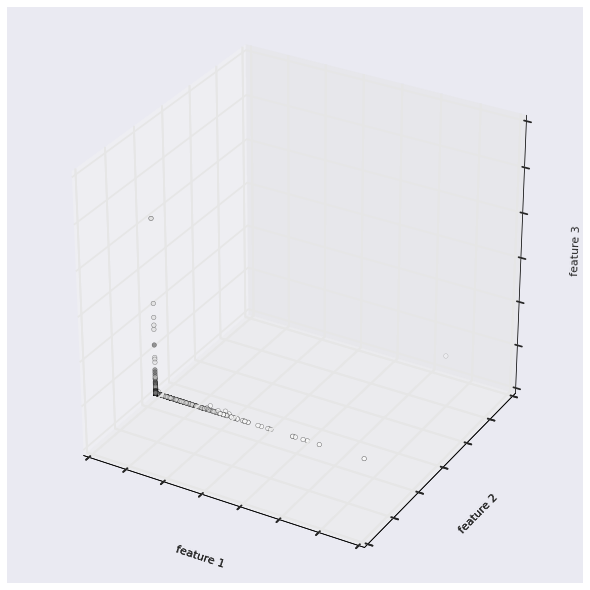

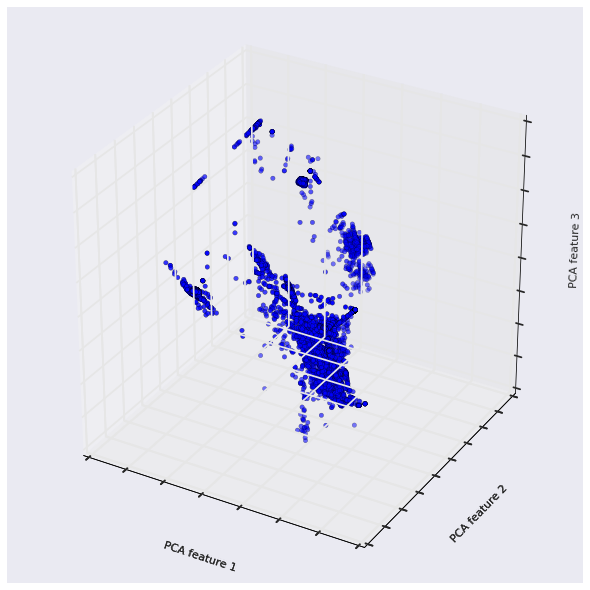

In [38]:
#plots
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter(datax_norm, datay_norm, dataz_norm, c=labels_norm)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

#pca plot
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter([x[0] for x in pcaData], [x[1] for x in pcaData], [x[2] for x in pcaData])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA feature 1')
ax.set_ylabel('PCA feature 2')
ax.set_zlabel('PCA feature 3')

plt.show()

In [39]:
feat1 = raw_data.map(lambda x : x.split(",")[1]).distinct().collect()
feat2 = raw_data.map(lambda x : x.split(",")[2]).distinct().collect()
feat3 = raw_data.map(lambda x : x.split(",")[3]).distinct().collect()

In [40]:
print("feature 1: length = %d\nfeatures = \n%s\n" %(len(feat1), feat1))
print("\nfeature 2: length = %d\nfeatures = \n%s\n" %(len(feat2), feat2))
print("\nfeature 3: length = %d\nfeatures = \n%s\n" %(len(feat3), feat3))

feature 1: length = 3
features = 
['udp', 'tcp', 'icmp']


feature 2: length = 70
features = 
['whois', 'pop_3', 'harvest', 'uucp_path', 'other', 'systat', 'ecr_i', 'vmnet', 'kshell', 'time', 'Z39_50', 'name', 'http', 'tftp_u', 'netbios_dgm', 'remote_job', 'ftp', 'domain_u', 'discard', 'ldap', 'eco_i', 'finger', 'http_2784', 'private', 'printer', 'sql_net', 'sunrpc', 'nnsp', 'iso_tsap', 'pop_2', 'exec', 'urp_i', 'daytime', 'netbios_ns', 'IRC', 'ftp_data', 'urh_i', 'http_443', 'bgp', 'domain', 'ctf', 'hostnames', 'mtp', 'netstat', 'login', 'klogin', 'nntp', 'ssh', 'imap4', 'aol', 'efs', 'X11', 'csnet_ns', 'rje', 'smtp', 'telnet', 'tim_i', 'shell', 'http_8001', 'supdup', 'red_i', 'pm_dump', 'courier', 'echo', 'ntp_u', 'netbios_ssn', 'uucp', 'gopher', 'auth', 'link']


feature 3: length = 11
features = 
['SH', 'OTH', 'S1', 'S2', 'REJ', 'RSTOS0', 'RSTO', 'S0', 'RSTR', 'S3', 'SF']



<div class="alert alert-success">
Let's plot the data and see how this categorical features split the data.
</div>

In [41]:
f1 = raw_data.map(lambda x : x.split(",")[1]).map(lambda x : (x, 1)).reduceByKey(add).collect()
f2 = raw_data.map(lambda x : x.split(",")[2]).map(lambda x : (x, 1)).reduceByKey(add).collect()
f3 = raw_data.map(lambda x : x.split(",")[3]).map(lambda x : (x, 1)).reduceByKey(add).collect()

f1.sort(key=lambda x : x[1], reverse=True)
f2.sort(key=lambda x : x[1], reverse=True)
f3.sort(key=lambda x : x[1], reverse=True)

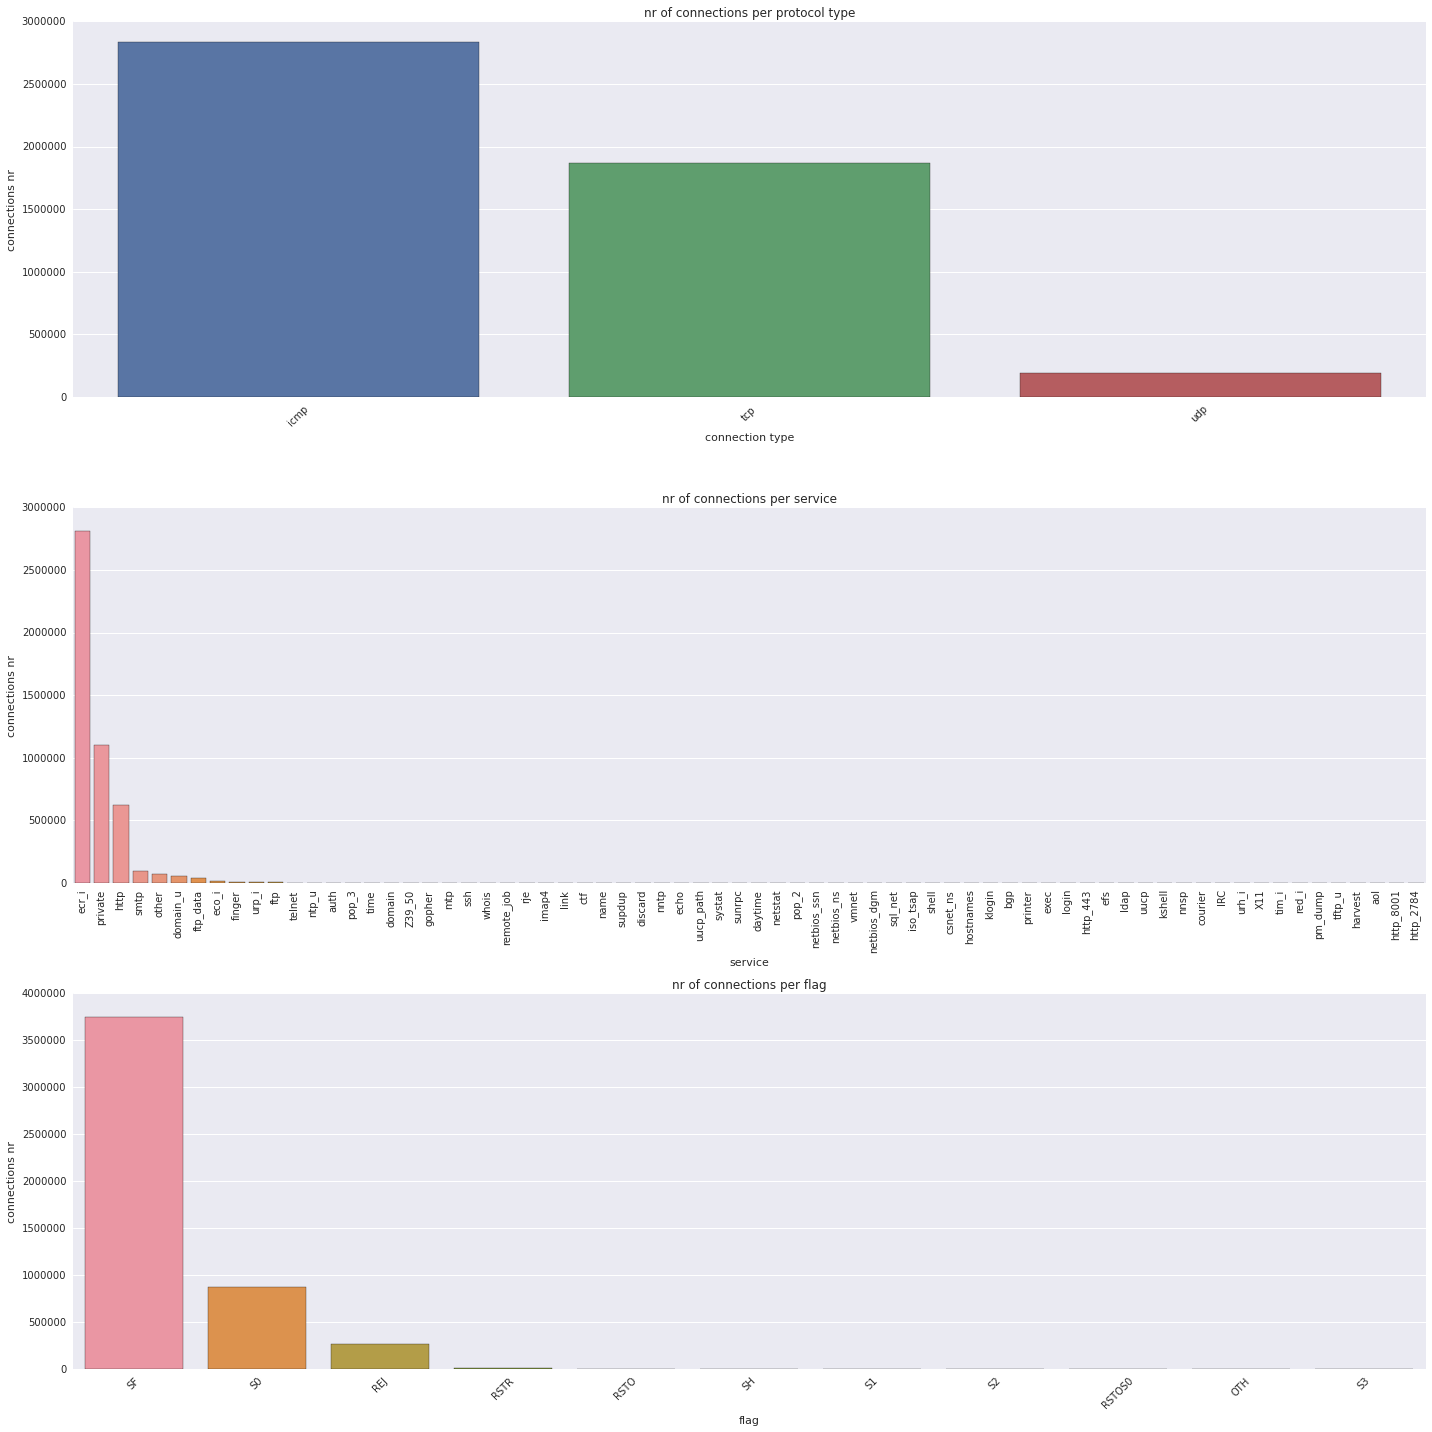

In [42]:
#plotting
a = plt.figure(figsize=(20,20))
plt.subplot(311)
sns.barplot(x=np.arange(len(f1)), y=[_[1] for _ in f1])
plt.xticks(np.arange(len(f1)), [_[0] for _ in f1], rotation=45)
plt.title("nr of connections per protocol type")
plt.xlabel("connection type")
plt.ylabel("connections nr")

plt.subplot(312)
sns.barplot(x=np.arange(len(f2)), y=[_[1] for _ in f2])
plt.xticks(np.arange(len(f2)), [_[0] for _ in f2], rotation="vertical")
plt.title("nr of connections per service")
plt.xlabel("service")
plt.ylabel("connections nr")

plt.subplot(313)
sns.barplot(x=np.arange(len(f3)), y=[_[1] for _ in f3])
plt.xticks(np.arange(len(f3)), [_[0] for _ in f3], rotation=45)
plt.title("nr of connections per flag")
plt.xlabel("flag")
plt.ylabel("connections nr")

plt.tight_layout()

plt.show()

In [43]:
def parseLineWithHotEncoding(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorical feature
    featureOfCol1 = [0]*len(feat1)
    featureOfCol1[feat1.index(vector[1])] = 1
    # the binary features that are encoded from the second categorical feature
    featureOfCol2 = [0]*len(feat2)
    featureOfCol2[feat2.index(vector[2])] = 1
    # the binary features that are encoded from the third categorical feature
    featureOfCol3 = [0]*len(feat3)
    featureOfCol3[feat3.index(vector[3])] = 1
    
    # construct the new vector
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLineWithHotEncoding)

# we only need the data, not the label
#data = labelsAndData.values().cache()

#with our normalizeData function, we can simply do:
labelsAndDataNorm = normalizeData(labelsAndData).cache()
normalizedData = labelsAndDataNorm.map(lambda x:x[1]).cache()

In [44]:
k_vector = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160]
scores = [clusteringScore(normalizedData, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =  20, (effective nr. of clusters =  14) WSSSE = 435035506
k =  30, (effective nr. of clusters =  16) WSSSE = 436673060
k =  40, (effective nr. of clusters =  26) WSSSE = 392159586
k =  50, (effective nr. of clusters =  23) WSSSE = 391542154
k =  60, (effective nr. of clusters =  33) WSSSE = 359513808
k =  70, (effective nr. of clusters =  34) WSSSE = 375972806
k =  80, (effective nr. of clusters =  44) WSSSE = 333023705
k =  90, (effective nr. of clusters =  50) WSSSE = 321442614
k = 100, (effective nr. of clusters =  58) WSSSE = 306675359
k = 110, (effective nr. of clusters =  49) WSSSE = 321356507
k = 120, (effective nr. of clusters =  59) WSSSE = 294232881
k = 130, (effective nr. of clusters =  57) WSSSE = 299496956
k = 140, (effective nr. of clusters =  81) WSSSE = 279224531
k = 150, (effective nr. of clusters =  70) WSSSE = 309188678
k = 160, (effective nr. of clusters =  74) WSSSE = 290637292


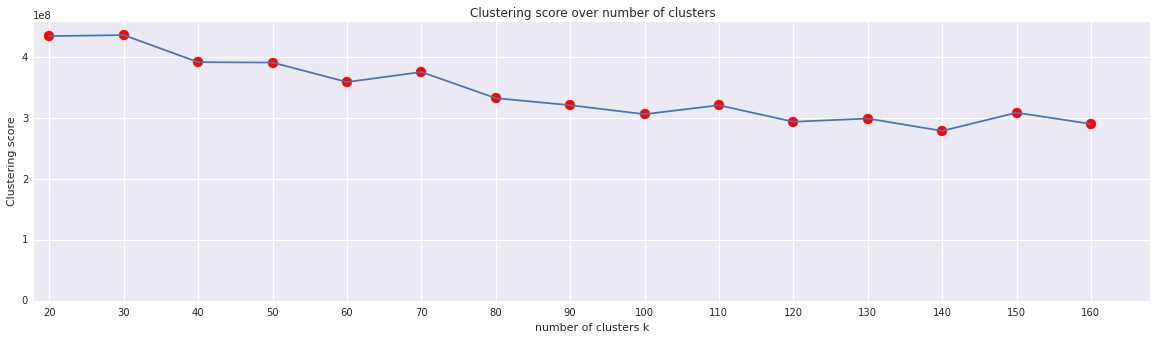

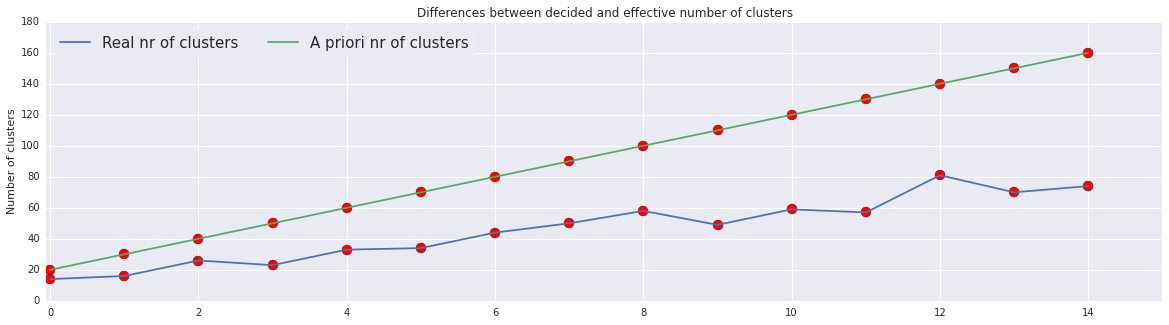

In [45]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([18, 1.05*np.max(k_vector), 0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.title("Clustering score over number of clusters")
plt.xticks(k_vector)
plt.show()

# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
plt.xlim([-0.05, np.max(len(k_vector))])
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

In [46]:
bestK = 90

In [47]:
clusters = KMeans.train(normalizedData, bestK, maxIterations=10, runs=10, initializationMode="random")

In [48]:
print("Initial k clusters:", bestK)
print("Effective clusters:", len(clusters.centers))

Initial k clusters: 90
Effective clusters: 39


In [49]:
ordered = normalizedData.map(lambda x : (error(clusters, x), x)).takeOrdered(10000, lambda key : -key[0])

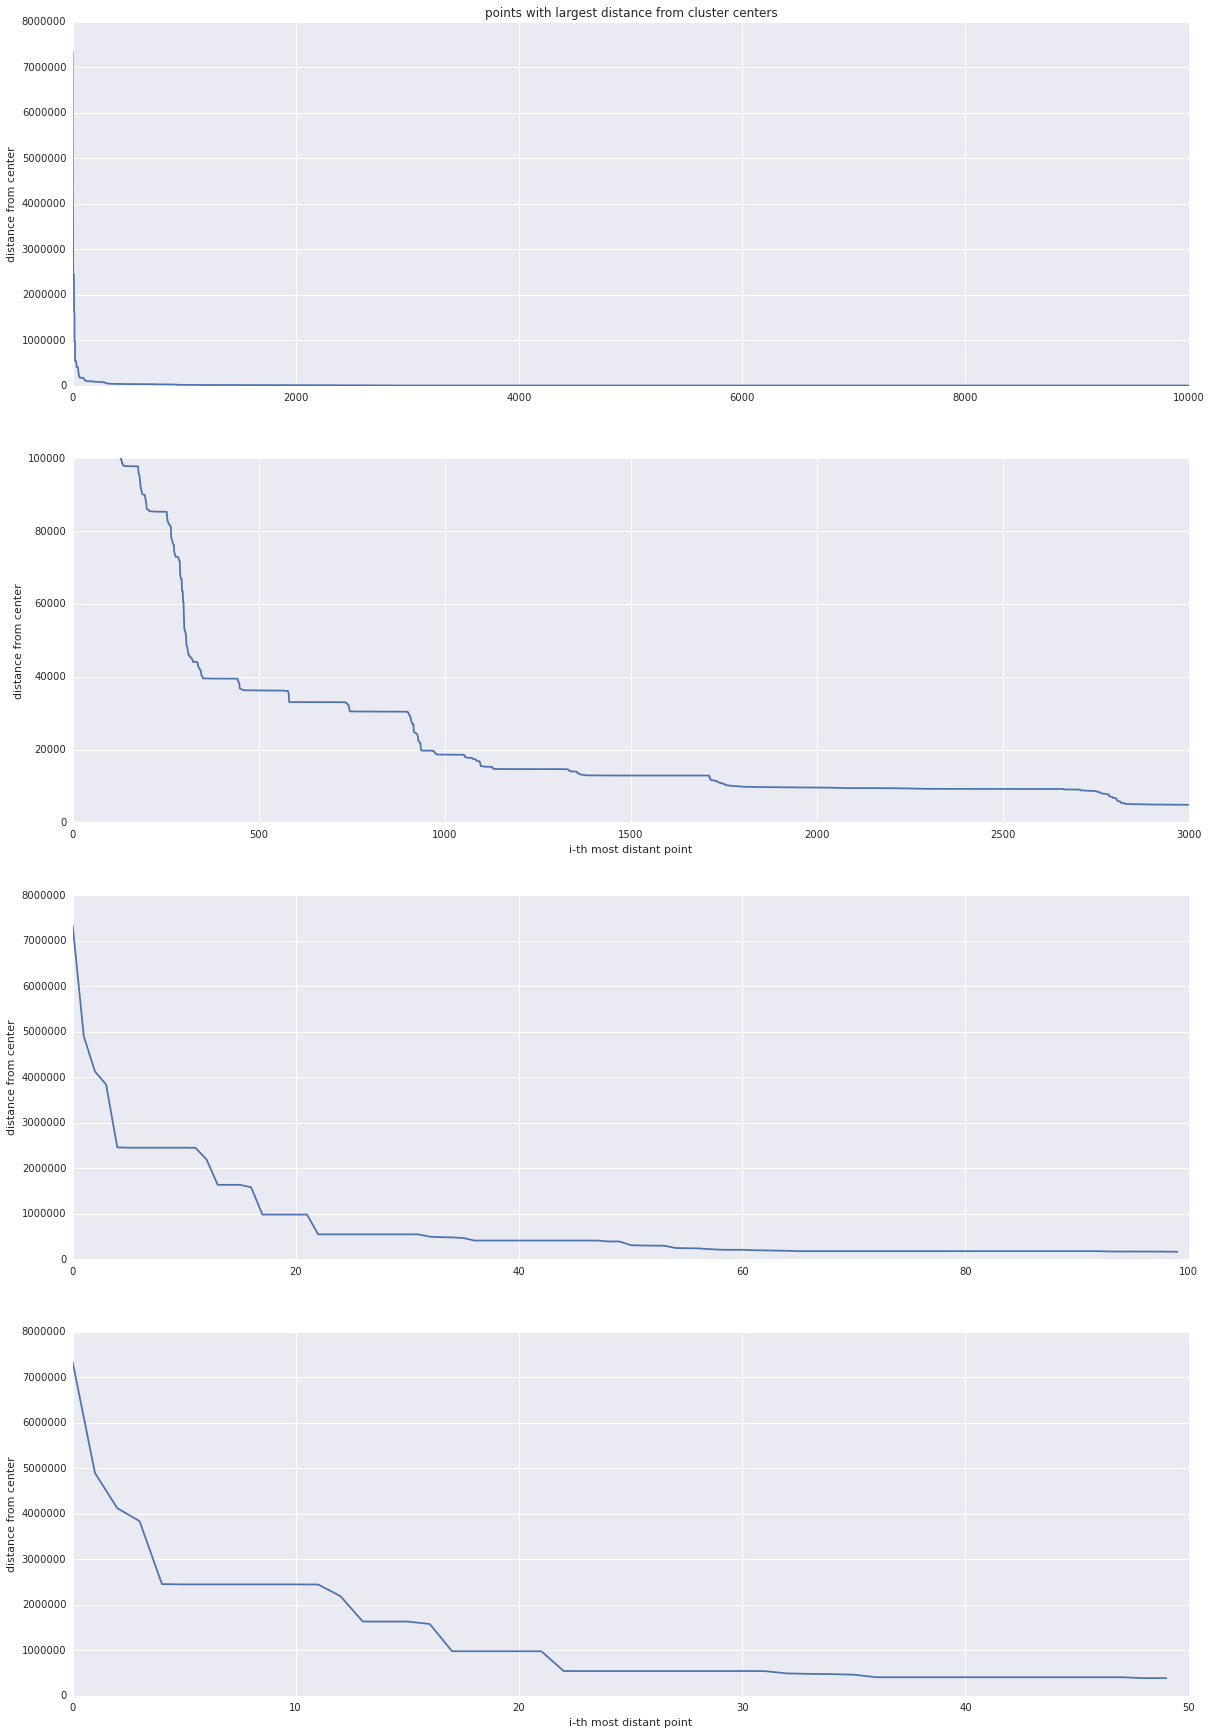

In [50]:
xx = [x[0] for x in ordered]
plt.figure(figsize=(20,30))
plt.subplot(411)
plt.plot(xx)
plt.title("points with largest distance from cluster centers")
plt.ylabel("distance from center")

plt.subplot(412)
plt.plot(xx[:3000])
plt.ylabel("distance from center")
plt.xlabel("i-th most distant point")
plt.ylim(0,100000)

plt.subplot(413)
plt.plot(xx[:100])
plt.ylabel("distance from center")

plt.subplot(414)
plt.plot(xx[:50])
plt.ylabel("distance from center")
plt.xlabel("i-th most distant point")
plt.show()

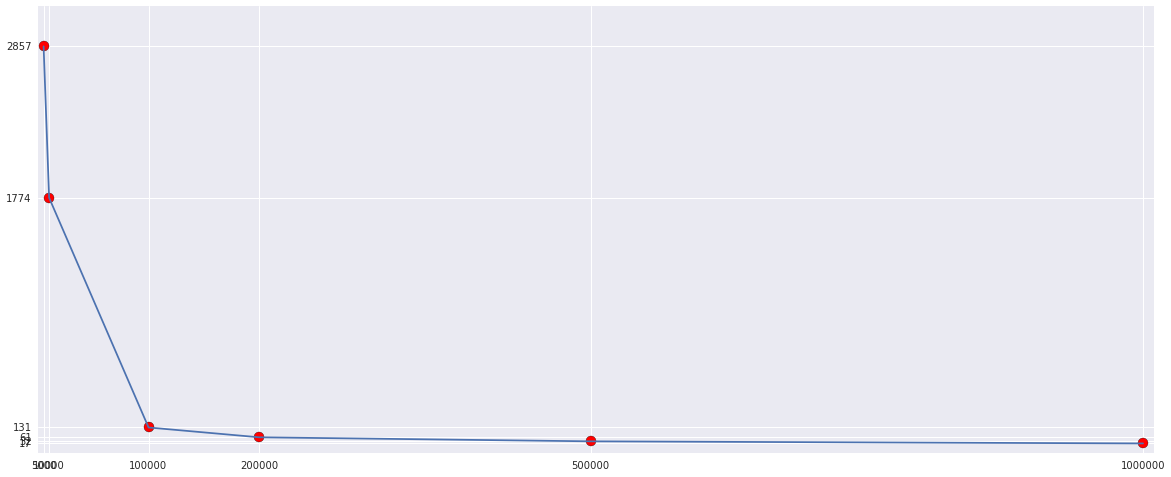

Threshold:    1000000	anomalous connections:    17
Threshold:     500000	anomalous connections:    32
Threshold:     200000	anomalous connections:    61
Threshold:     100000	anomalous connections:   131
Threshold:      10000	anomalous connections:  1774
Threshold:       5000	anomalous connections:  2857


In [51]:
thresholds = [1000000, 500000, 200000, 100000, 10000, 5000]
t_count = [len([__ for __ in xx if __ > _]) for _ in thresholds]

plt.figure(figsize=(20,8))
plt.scatter(thresholds, t_count, c="r", s=100)
plt.plot(thresholds, t_count)
plt.yticks(t_count)
plt.xticks(thresholds)
plt.ylim(-50, np.max(t_count)*1.1)
plt.xlim(0, np.max(thresholds)*1.01)
plt.show()

for i in range(len(thresholds)):
    print("Threshold: %10d\tanomalous connections: %5d" %(thresholds[i], t_count[i]))

In [52]:
currThre = 5000
y = labelsAndDataNorm.map(lambda x : (x[0], error(clusters, x[1]))).filter(lambda x: x[1]>currThre) \
                    .map(lambda x : (x[0], 1)).reduceByKey(add).collect()

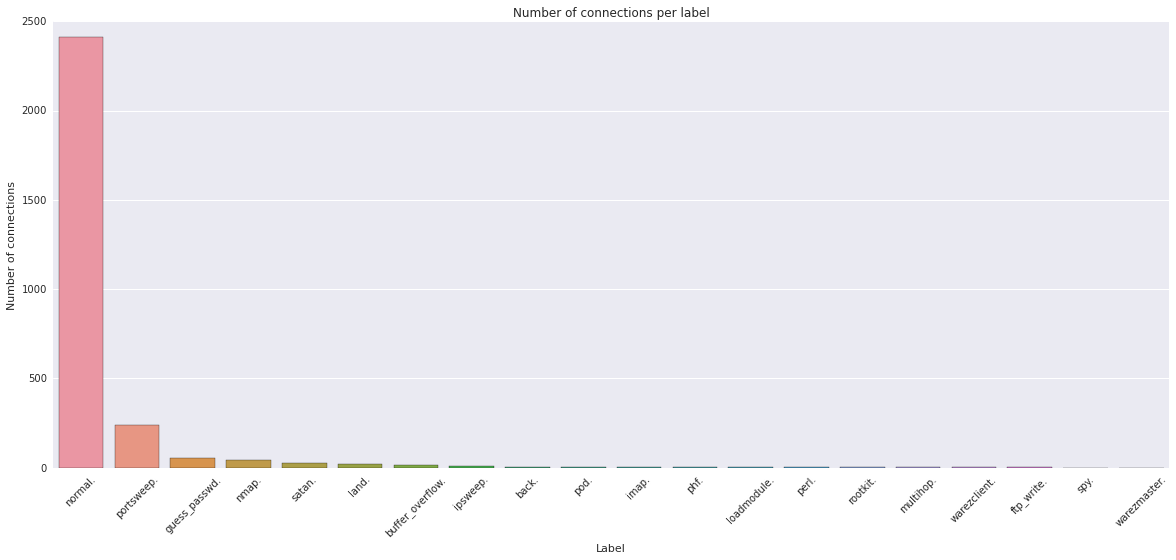

In [53]:
y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

In [64]:
currThre = 100000
y = labelsAndDataNorm.map(lambda x : (x[0], error(clusters, x[1]))).filter(lambda x: x[1]>currThre) \
                    .map(lambda x : (x[0], 1)).reduceByKey(add).collect()

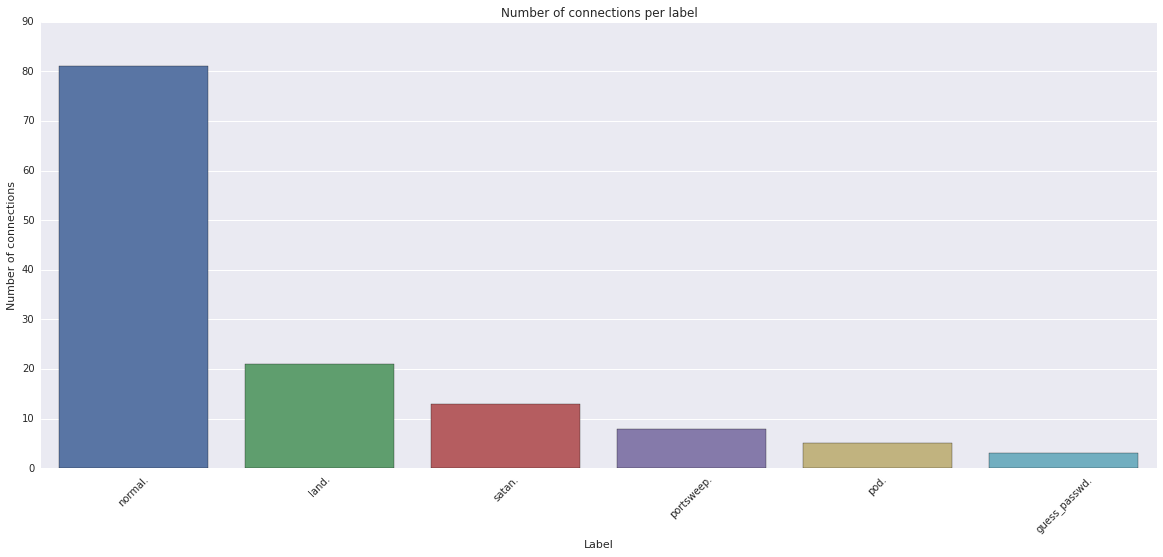

In [65]:
y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

In [54]:
def label_entropy(label_count, cluster_count):
    ratio = label_count / cluster_count
    return -ratio * np.log2(ratio)

def clusteringEntropy(labeled_data, model):
    total = labeled_data.count()
    # returns the number of occurrency of each pair (label, assigned_cluster)
    labels_with_cluster = labeled_data.map(lambda x : ((x[0], model.predict(x[1])), 1)).reduceByKey(add).cache()
    # contains the number of element for each cluster
    labels_dist = labels_with_cluster.map(lambda x : (x[0][1], x[1])).reduceByKey(add).collectAsMap()
    labels_ratio = {key:labels_dist[key]/total for key in labels_dist}
    clusters_entropy = labels_with_cluster.map(lambda x: (x[0][1], label_entropy(x[1], labels_dist[x[0][1]])))\
                        .reduceByKey(add)
    total_entropy = clusters_entropy.map(lambda x : x[1]*labels_ratio[x[0]]).sum()
    return total_entropy

In [55]:
clusteringEntropy(labelsAndDataNorm, clusters)

0.032290780147120585

In [56]:
import matplotlib.cm as cm

def plot_silhouette(clusters, data):
    t1 = time.time()
    
    def calc_silhouette(point, centers):
        nearest_centers = [euclidean_distance(_, point) for _ in centers]
        nearest_centers = sorted(nearest_centers)
        return 1-(nearest_centers[0]/nearest_centers[1])
    
    # Compute the silhouette scores for each sample
    centers = clusters.centers
    k = len(centers)
    bCenters = sc.broadcast(centers)
    sil = data.map(lambda x:(x, clusters.predict(x), calc_silhouette(x, bCenters.value))).cache()
    silhouette_avg = sil.map(lambda x:x[2]).mean()
    print("The average silhouette is:", silhouette_avg)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches([20, k*3/8])
    ax1.set_xlim([-0.1, 1])
    y_lower = 10

    for i in range(k):
        ith_cluster_silhouette_values = sil.filter(lambda x:x[1] == i).sample(False, 0.5) \
                    .sortBy(lambda x:x[2]).map(lambda x:x[2]).collect()
        ith_cluster_silhouette_values = np.array(ith_cluster_silhouette_values)

        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        if i % 5 == 0:
            ax1.text(-0.05, (y_lower + y_upper) / 2, str(i))


        y_lower = y_upper + 10 

    print("time taken:", time.time()-t1)
    
    ax1.set_title("The silhouette plot for the various clusters with K = "+str(k))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")


    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

The average silhouette is: 0.813032988882
time taken: 708.0251262187958


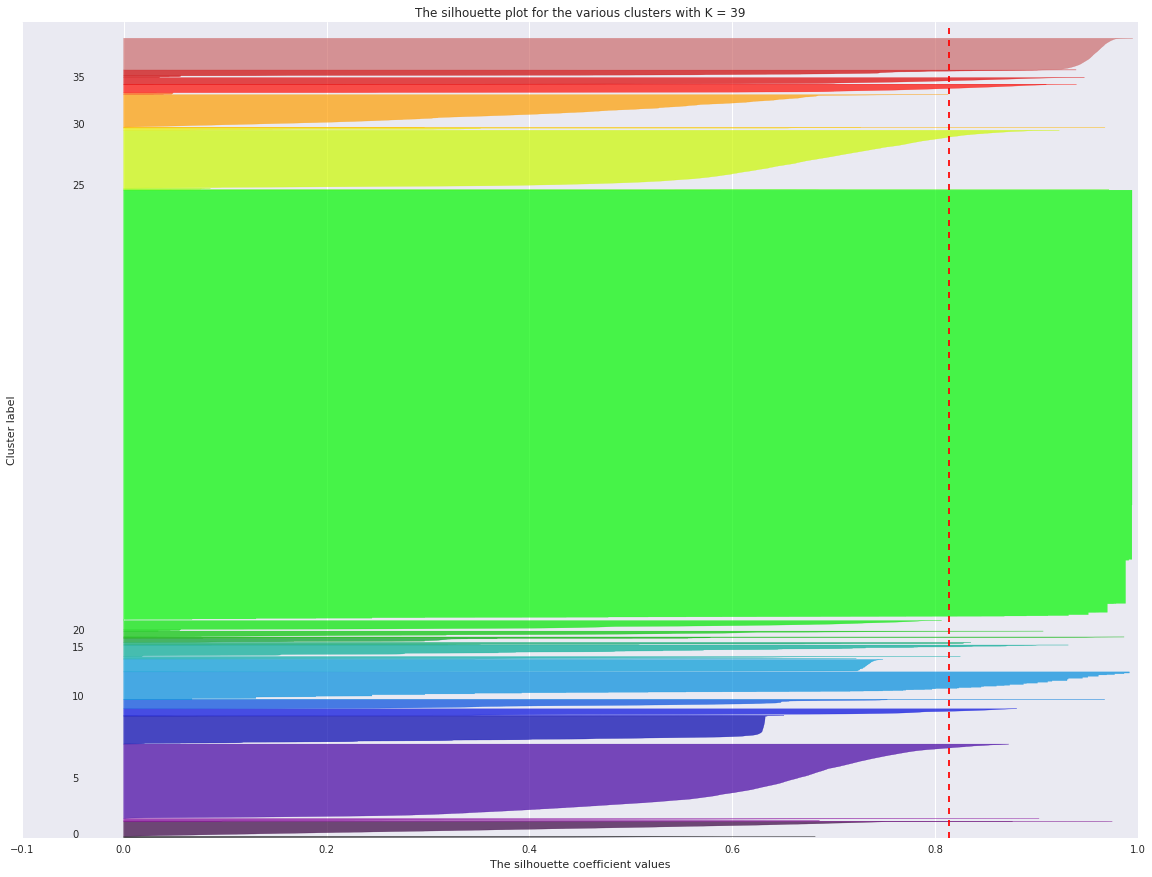

In [57]:
plot_silhouette(clusters, normalizedData)

The average silhouette is: 0.736502384001
time taken: 1201.3258986473083


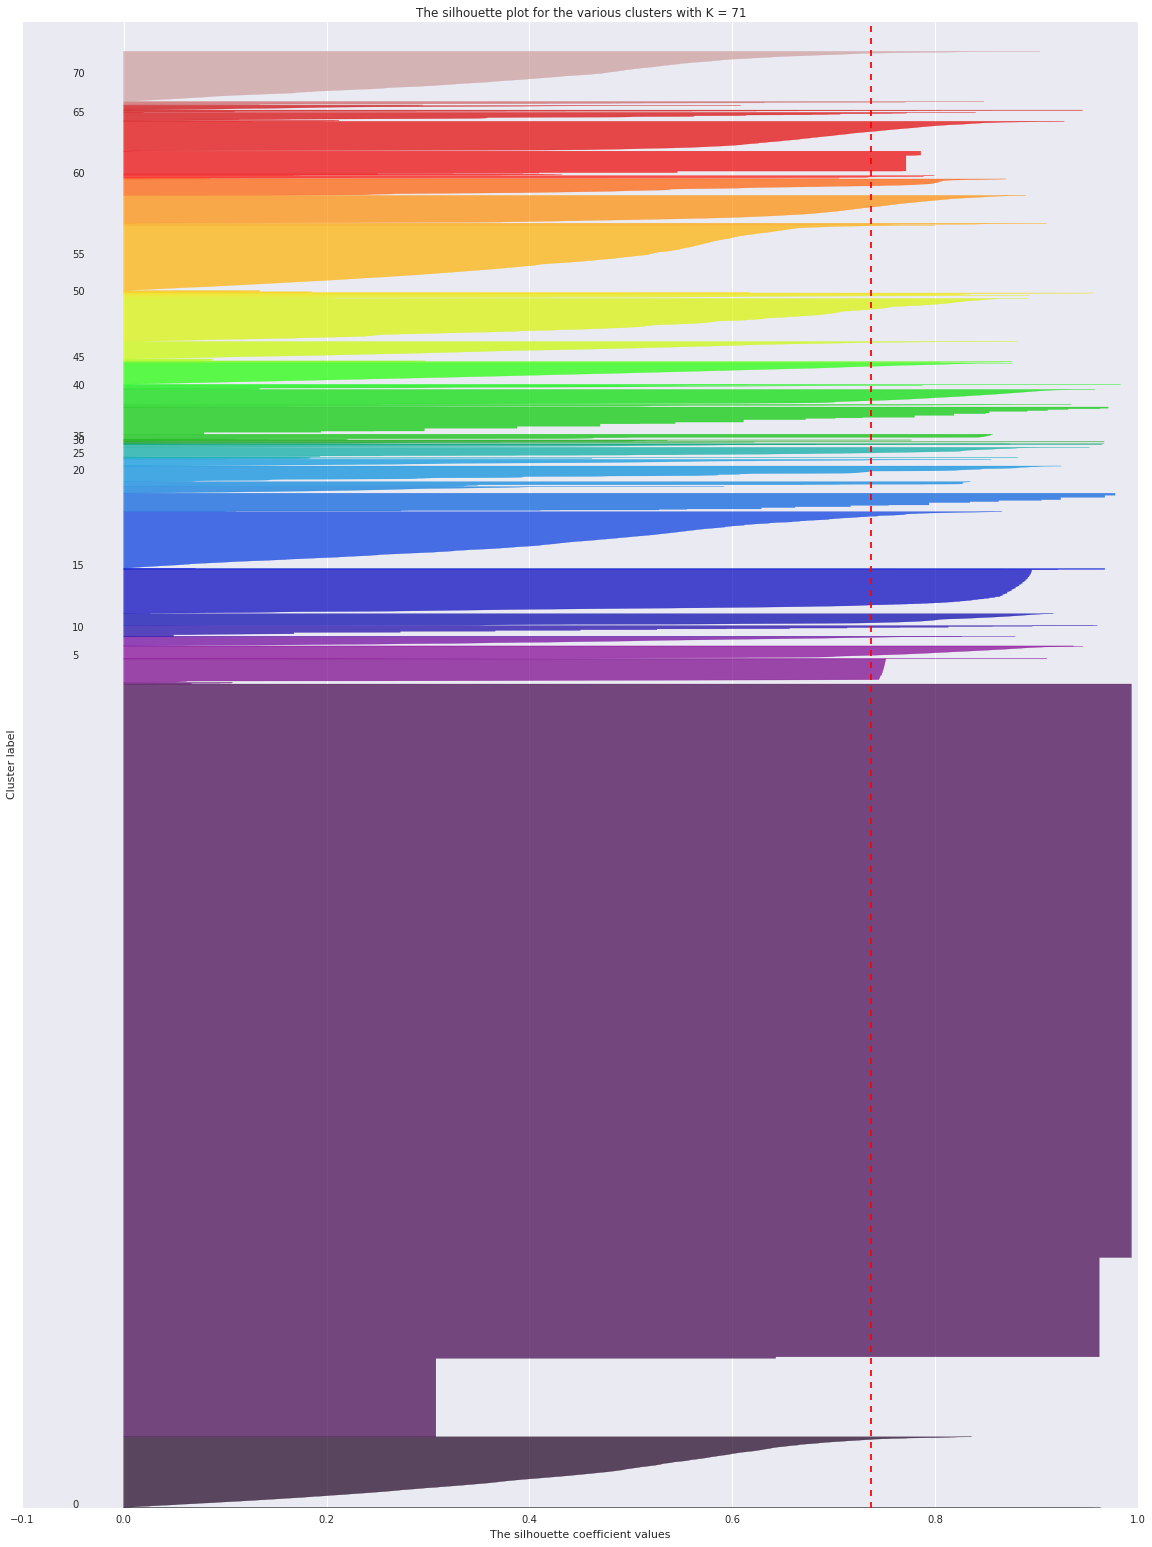

In [67]:
clusters160 = KMeans.train(normalizedData, 160, maxIterations=10, runs=10, initializationMode="random")
plot_silhouette(clusters160, normalizedData)

In [58]:
from pyspark import AccumulatorParam

class VectorAccumulatorParam(AccumulatorParam):
    def zero(self, initialAcc):
        l = len(initialAcc)
        sums = np.zeros([l, 122])
        counts = np.zeros(l)
        return [sums, counts]

    def addInPlace(self, v1, v2):
        v1[0] += v2[0]
        v1[1] += v2[1]
        return v1

def mapping(iterator, centers):
    sums = np.zeros([len(centers), 122])
    counts = np.zeros(len(centers))
    for x in iterator:
        i = find_closest_centroid(x, centers)
        sums[i] += x
        counts[i] += 1
    acc.add([sums, counts])
    yield

def getError(centroids, data):
    bCentroids = sc.broadcast(centroids)
    return data.map(lambda x : euclidean_distance(bCentroids.value[find_closest_centroid(x, bCentroids.value)], x)) \
            .reduce(add)

def KMeansTrain(data, k=2, runs=1, maxIterations=20, centroids=None, threshold=0, verbose=False):
    bestError = float("inf")
    sums = np.zeros([k, len(normalizedData.first())])
    counts = np.zeros(k)
    initialAcc =  [sums, counts]
    bestCentroids = None
    
    if verbose is True:
        t0 = time.time()
    
    for _ in range(runs):
        
        if verbose is True:
            t1 = time.time()
            print("Starting run #",_)
        
        # randomize the centroids if they are not given
        if not centroids:
            centroids = data.takeSample(withReplacement=False, num=k)

        iterations = 0
        while True:
            iterations += 1

            #broadcast current centroids
            bCentroids = sc.broadcast(centroids)

            acc = sc.accumulator(initialAcc, VectorAccumulatorParam())
            global acc
            
            
            #assign each data point to the closest centroid
            data.mapPartitions(lambda iterator: mapping(iterator, bCentroids.value)).collect()
            #update centroids
            old_centroids = centroids
            centroids = np.array([s/c for s, c in zip(acc.value[0], acc.value[1])])

            # if the stop criteria are met, stop the algorithm
            if check_converge(old_centroids, bCentroids.value, iterations, threshold):
                break
        
        currError = getError(bCentroids.value, data)
        if currError < bestError:
            bestError = currError
            bestCentroids = centroids
        
        if verbose is True:
            t3 = time.time()
            print("Finished run #"+str(_)+"/"+str(runs),"in",t3-t1, "seconds; Total elapsed time:", t3-t0)
                    
    return bestCentroids

In [60]:
myClusters = KMeansTrain(normalizedData, verbose=True)

Starting run # 0
Finished run #0/1 in 181.416606426239 seconds; Total elapsed time: 181.41661167144775
